In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

2022-09-01 19:12:48.823862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 19:12:48.963871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 19:12:48.964722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 19:12:48.966456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510], dtype=int32)>

In [2]:
# Opening the dataframe
ABB_data = pd.read_csv('../input/electricity-demand/Multivariate_Labeled_2.csv', parse_dates=['DateTime'], delimiter=',')
ABB_data.drop(columns="DateTime", inplace=True)
ABB_data

,CB_First_Floor,CB_Second_Floor,AvgT,AvgH,Anomaly_Label,Year,Month,Day,Hour,Min,Sec,Day_Of_The_Week
0,37.0,36.0,4.70,80.40,0.0,2017.0,2.0,9.0,0.0,0.0,0.0,3.0
1,32.0,33.0,4.75,79.35,0.0,2017.0,2.0,9.0,0.0,15.0,0.0,3.0
2,32.0,32.0,4.60,78.90,0.0,2017.0,2.0,9.0,0.0,30.0,0.0,3.0
3,32.0,33.0,4.50,79.25,0.0,2017.0,2.0,9.0,0.0,45.0,0.0,3.0
4,33.0,33.0,4.40,80.40,0.0,2017.0,2.0,9.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75835,41.0,41.0,10.95,83.25,0.0,2019.0,4.0,9.0,22.0,45.0,0.0,1.0
75836,42.0,42.0,10.80,84.60,0.0,2019.0,4.0,9.0,23.0,0.0,0.0,1.0
75837,43.0,43.0,10.65,86.05,0.0,2019.0,4.0,9.0,23.0,15.0,0.0,1.0
75838,42.0,42.0,10.30,86.90,0.0,2019.0,4.0,9.0,23.0,30.0,0.0,1.0


In [3]:
# Dataframe preprocessing

# Converting data types
ABB_data['CB_First_Floor'] = ABB_data['CB_First_Floor'].astype(np.float32)
ABB_data['CB_Second_Floor'] = ABB_data['CB_Second_Floor'].astype(np.float32)
ABB_data['AvgT'] = ABB_data['AvgT'].astype(np.float32)
ABB_data['AvgH'] = ABB_data['AvgH'].astype(np.float32)
ABB_data['Anomaly_Label'] = ABB_data['Anomaly_Label'].astype(np.float32)
ABB_data['Year'] = ABB_data['Year'].astype(np.float32)
ABB_data['Month'] = ABB_data['Month'].astype(np.float32)
ABB_data['Day'] = ABB_data['Day'].astype(np.float32)
ABB_data['Hour'] = ABB_data['Hour'].astype(np.float32)
ABB_data['Min'] = ABB_data['Min'].astype(np.float32)
ABB_data['Sec'] = ABB_data['Sec'].astype(np.float32)
ABB_data['Day_Of_The_Week'] = ABB_data['Day_Of_The_Week'].astype(np.float32)

# Printing the dataframe's info
ABB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75840 entries, 0 to 75839
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CB_First_Floor   75840 non-null  float32
 1   CB_Second_Floor  75840 non-null  float32
 2   AvgT             75840 non-null  float32
 3   AvgH             75840 non-null  float32
 4   Anomaly_Label    75840 non-null  float32
 5   Year             75840 non-null  float32
 6   Month            75840 non-null  float32
 7   Day              75840 non-null  float32
 8   Hour             75840 non-null  float32
 9   Min              75840 non-null  float32
 10  Sec              75840 non-null  float32
 11  Day_Of_The_Week  75840 non-null  float32
dtypes: float32(12)
memory usage: 3.5 MB


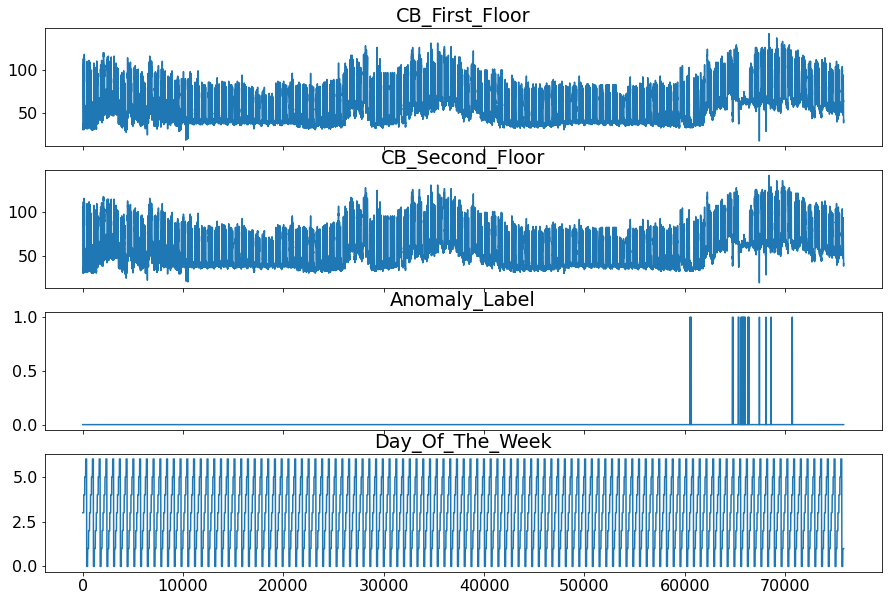

In [4]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(15,10))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]].columns)

In [5]:
# Columns used for the following split in train, test and validation sets
ABB_data['Test'] = 0
ABB_data['Validation'] = 0
ABB_data['Train_P1'] = 0
ABB_data['Train_P2'] = 0

In [6]:
# TEST SET

# Some random weeks
week = [89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    ABB_data.iloc[(j)*672:(j+1)*672]['Test'] = 1

In [7]:
# VALIDATION SET

# Some random weeks
week = [55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    ABB_data.iloc[(j)*672:(j+1)*672]['Validation'] = 1

In [8]:
# TRAINING SET

week = [x for x in np.arange(0, 55, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    ABB_data.iloc[(j)*672:(j+1)*672]['Train_P1'] = 1
    
week = [x for x in np.arange(79, 89, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    ABB_data.iloc[(j)*672:(j+1)*672]['Train_P2'] = 1

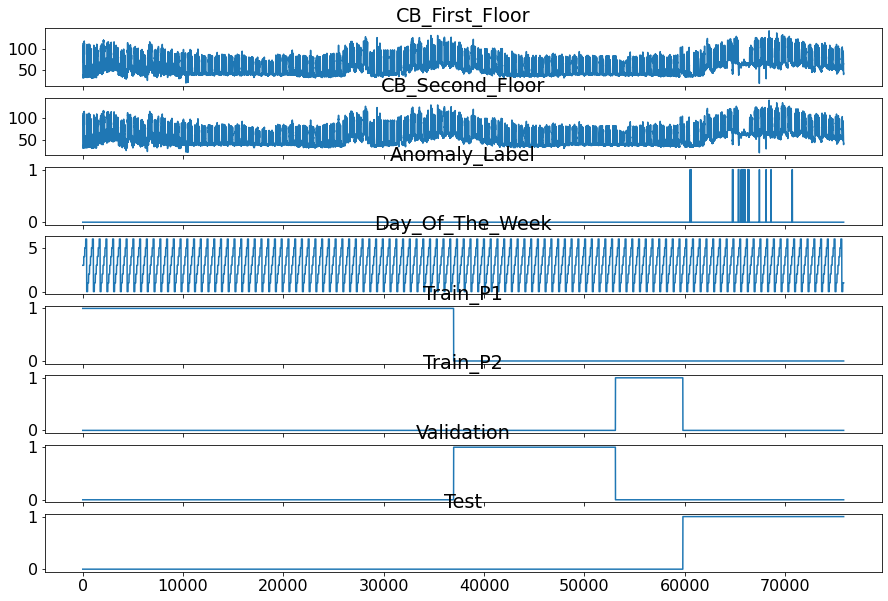

In [9]:
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]].columns)

In [10]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = ABB_data[ABB_data['Train_P1']==1].copy()
X_train_temp_P2 = ABB_data[ABB_data['Train_P2']==1].copy()
X_validation_temp = ABB_data[ABB_data['Validation']==1].copy()
X_test_temp = ABB_data[ABB_data['Test']==1].copy()

In [11]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly_Label']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly_Label']]
Anomaly_Validation = X_validation_temp[['Anomaly_Label']]
Anomaly_Test = X_test_temp[['Anomaly_Label']]

In [12]:
X_train_temp_global = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global.shape

(43680, 16)

In [13]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0] == ABB_data.shape[0])

CB_First_Floor       56.138874
CB_Second_Floor      55.814743
AvgT                 14.077893
AvgH                 71.934387
Anomaly_Label         0.000000
Year               2017.283569
Month                 6.725275
Day                  15.931869
Hour                 11.500000
Min                  22.500000
Sec                   0.000000
Day_Of_The_Week       3.000000
Test                  0.000000
Validation            0.000000
Train_P1              0.846154
Train_P2              0.153846
dtype: float64 CB_First_Floor     19.434896
CB_Second_Floor    19.353765
AvgT                8.412517
AvgH               19.357885
Anomaly_Label       0.000000
Year                0.450710
Month               3.393199
Day                 8.644081
Hour                6.922266
Min                16.770702
Sec                 0.000000
Day_Of_The_Week     2.000023
Test                0.000000
Validation          0.000000
Train_P1            0.360805
Train_P2            0.360805
dtype: float64
True


In [14]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P2 = X_train_raw_P2[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_validation_raw = X_validation_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_test_raw = X_test_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_validation_raw.shape, X_test_raw.shape

((36960, 3), (6720, 3), (16128, 3), (16032, 3))

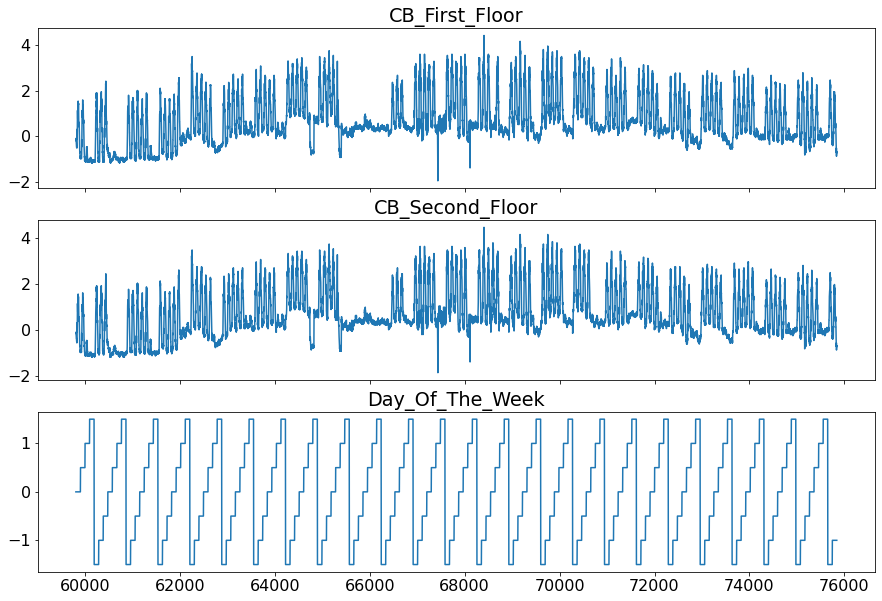

In [15]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training Preparation

In [16]:
# Training parameters

window = 672       # 1 week
stride = 8         # 1 hour
latent_dim = 9     # Latent dimension
epochs = 300       # Number of epochs (no early stopping)
batch_size = 8     # Batch size

In [17]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [18]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape

PADDING: 0
PADDING: 0
PADDING: 0


((4537, 672, 3), (757, 672, 3))

In [19]:
# Temp test set - plotting purposes
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=stride)

PADDING: 0


In [20]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
X_train.shape, A_train.shape

((5294, 672, 3), (5294, 672, 1))

In [21]:
# Building the model

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

#Encoder
encoder_input = tf.keras.Input(shape=input_shape)

convlstm = tfkl.LSTM(64, return_sequences=True)(encoder_input)
convlstm = tfkl.LSTM(latent_dim, return_sequences=False)(convlstm)

#Decoder
convlstm = tfkl.RepeatVector(window)(convlstm)
convlstm = tfkl.LSTM(64, return_sequences=True)(convlstm)
decoder_output = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(convlstm)

#Model
autoencoder = tfk.Model(inputs=encoder_input, outputs=decoder_output, name='Autoencoder')
autoencoder.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.MeanSquaredError()])
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 672, 3)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 672, 64)           17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 9)                 2664      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 672, 9)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 672, 64)           18944     
_________________________________________________________________
time_distributed (TimeDistri (None, 672, 3)            195       
Total params: 39,211
Trainable params: 39,211
Non-trainable params: 0
___________________________________________________

In [22]:
# Training
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = (X_val,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

2022-09-01 19:12:55.862260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-09-01 19:13:00.287271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


662/662 [==============================] - 54s 72ms/step - loss: 0.9536 - mean_squared_error: 0.9536 - val_loss: 0.7858 - val_mean_squared_error: 0.7858
Epoch 2/300
662/662 [==============================] - 47s 71ms/step - loss: 0.9333 - mean_squared_error: 0.9333 - val_loss: 0.7524 - val_mean_squared_error: 0.7524
Epoch 3/300
662/662 [==============================] - 47s 71ms/step - loss: 0.8961 - mean_squared_error: 0.8961 - val_loss: 0.7414 - val_mean_squared_error: 0.7414
Epoch 4/300
662/662 [==============================] - 47s 71ms/step - loss: 0.8852 - mean_squared_error: 0.8851 - val_loss: 0.7405 - val_mean_squared_error: 0.7405
Epoch 5/300
662/662 [==============================] - 47s 72ms/step - loss: 0.8807 - mean_squared_error: 0.8807 - val_loss: 0.8053 - val_mean_squared_error: 0.8053
Epoch 6/300
662/662 [==============================] - 47s 71ms/step - loss: 0.9016 - mean_squared_error: 0.9016 - val_loss: 0.7404 - val_mean_squared_error: 0.7404
Epoch 7/300
662/662 [=

## Example of prediction on the test set

In [23]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [24]:
# Example of prediction on the test set
i = 1
j = i+1
Univariate_print = X_test_raw.iloc[i*672:j*672].copy()
X = np.expand_dims(Univariate_print, axis=0)
prediction = autoencoder.predict(X)
prediction.shape

(1, 672, 3)

In [25]:
# Adding anomalies to the plot (not used during training)
anomaly = X_test_temp['Anomaly_Label'].iloc[i*672:j*672].copy()

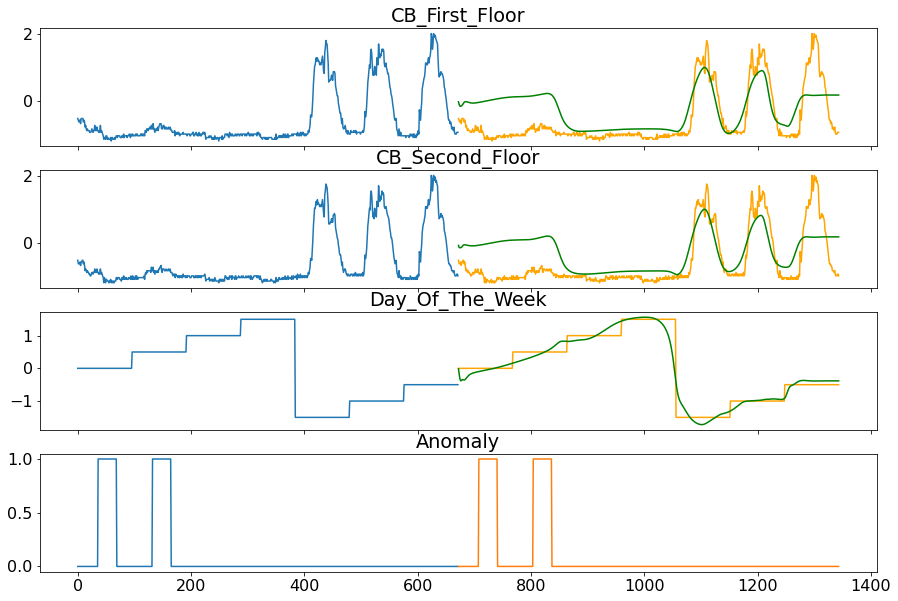

In [26]:
# Function to plot expected values and predicted values
target_labels = X_test_raw.columns

def inspect_multivariate_prediction(X, y, a, pred, columns): 
   
    figs, axs = plt.subplots(4, 1, sharex=True, figsize=(15,10)) 
    for i, col in enumerate(columns[:4]): 
        axs[i].plot(np.arange(len(X[0,:,i])), X[0,:,i]) 
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), y[0,:,i], color='orange') 
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), pred[0,:,i], color='green') 
        axs[i].set_title(col) 
            
    axs[3].plot(np.arange(len(X[0,:,i])), a) 
    axs[3].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), a) 
    axs[3].set_title('Anomaly') 
    plt.show()
    
# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly, prediction, target_labels)

## Computing reconstruction error

In [27]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [28]:
# Non overlapped windows - Training set
X_train_non_overlapped_P1 = build_sequences_reconstruction(X_train_raw_P1, window=window, stride=window)
X_train_non_overlapped_P2 = build_sequences_reconstruction(X_train_raw_P2, window=window, stride=window)

X_train_non_overlapped = np.concatenate([X_train_non_overlapped_P1,X_train_non_overlapped_P2],axis=0)

X_train_non_overlapped.shape

(65, 672, 3)

In [29]:
X_test_overlapped = build_sequences_reconstruction(X_test_raw, window=window, stride=stride)

X_test_overlapped.shape

(1921, 672, 3)

In [30]:
# Making predictions on non-overlapped windows of the training set
train_reconstructions = autoencoder.predict(X_train_non_overlapped)
train_reconstructions.shape

(65, 672, 3)

In [31]:
# Making predictions on overlapped windows of the test set
test_reconstructions = autoencoder.predict(X_test_overlapped)
test_reconstructions.shape

(1921, 672, 3)

In [32]:
# Computing reconstruction error - Test set (redundant data because of overlapping)
rec_error = np.abs(X_test_overlapped-test_reconstructions) # || True - Predicted ||
rec_error.shape

(1921, 672, 3)

In [33]:
# Function used to plot predictions (reconstructions) made on training data using the model
def inspect_multivariate_prediction_reconstruction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))
        print('Plotting sequence number: ' + str(idx))

    figs, axs = plt.subplots(4, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns[:4]):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

Plotting sequence number: 51


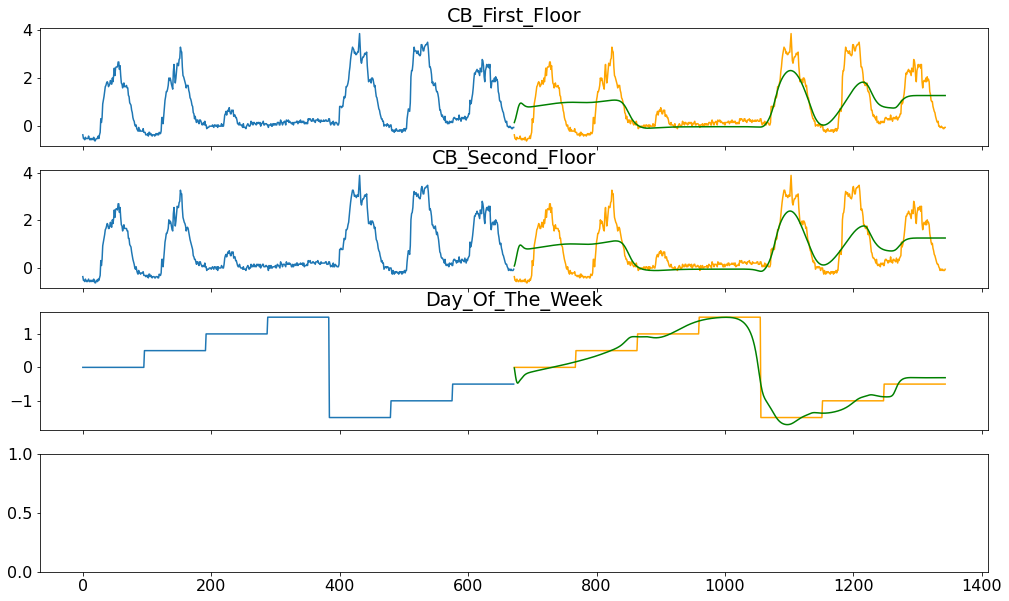

In [34]:
# Plotting reconstructions
inspect_multivariate_prediction_reconstruction(X_train_non_overlapped, X_train_non_overlapped, A_train, train_reconstructions, target_labels, window)

In [35]:
# Array that will contain reconstruction errors (floor by floor) - TRAINING SET
reconstruction_errors = np.empty(shape=(0, 2))

# Computing reconstruction errors
for i in range(X_train_non_overlapped.shape[0]):
    error = np.abs(X_train_non_overlapped[i]-train_reconstructions[i])
    error = error[:,:2] # Not interested in the day of the week
    reconstruction_errors = np.concatenate((reconstruction_errors,error), axis=0)
    
mean_error = np.mean(reconstruction_errors, axis = 0) # Mean reconstruction error
std_error = np.std(reconstruction_errors, axis = 0) # Std dev of the reconstruction error
max_error = np.max(reconstruction_errors, axis = 0) # Max error on the training set
  
print(reconstruction_errors.shape)
print(mean_error)
print(std_error)
print(max_error)

(43680, 2)
[0.47072234 0.47156134]
[0.4269545  0.42565713]
[3.17877708 3.16314411]


In [36]:
# Array that will contain reconstruction errors (floor by floor) - TEST SET

reconstruction_test = np.empty(shape=(0, 2)) # Predictions made on the test set using the model
reconstruction_errors_test = np.empty(shape=(0, 2)) # Errors made in predicting the test set

# First window
i = 0
error = np.abs(X_test_overlapped[i]-test_reconstructions[i])
error = error[:,:2] # Not interested in the day of the week
reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,:,:2]), axis=0)
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

# For all the windows following the first one we need to consider only the last "stride" elements
for i in range(1,X_test_overlapped.shape[0]):
    error = np.abs(X_test_overlapped[i,-stride:,:]-test_reconstructions[i,-stride:,:])
    error = error[:,:2] # Not interested in the day of the week
    reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
    reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,-stride:,:2]), axis=0)
                                        
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

(672, 2)
(672, 2)
(16032, 2)
(16032, 2)


In [37]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_errors, error_threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=(X_test_raw.shape[0]))
    
    # First window
    i = 0 # We start from element 0 of the test set
    seq = reconstruction_errors[0] # We start from the first window of the test set 
    for sample in seq: 
        epsilon = sample[:2] - error_threshold # We check if the reconstruction error is greater than the threshold
        if any(x>0 for x in epsilon) == True:
            anomaly_predicted[i] = 1
        i = i+1
            
    # Sequences following the first one
    for s in range(1, reconstruction_errors.shape[0]):
        for k in range (reconstruction_errors.shape[1]-stride, reconstruction_errors.shape[1]): # k in [672-stride, 672]         
            epsilon = reconstruction_errors[s,k,:2] - error_threshold # We check if the reconstruction error is greater than the threshold
            if any(x>0 for x in epsilon) == True:
                anomaly_predicted[i] = 1
            i = i+1 

    return anomaly_predicted

In [38]:
# Grid search threshold parameters

range_of_val = [x for x in np.arange(4, 8, 0.1)]
best_val = [0,0]
F1_MAX = 0

for i in range_of_val:
    for j in range_of_val:
        threshold_error_mean_std_TEMP = 0
        threshold_error_mean_std_TEMP = mean_error + [i,j]*std_error # mean + n*std_dev
        anomaly_predicted_mean_std_TEMP = 0
        anomaly_predicted_mean_std_TEMP = predict_anomalies(rec_error, threshold_error_mean_std_TEMP)
        f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted_mean_std_TEMP)
        if(f1>F1_MAX):
            F1_MAX = f1
            best_val = [i,j]
            print("best threshold parameters: " + str(best_val) + " best f1: " + str(F1_MAX))
            
threshold_error_mean_std = mean_error + [best_val[0],best_val[1]]*std_error # mean + n*std_dev
anomaly_predicted_mean_std = predict_anomalies(rec_error, threshold_error_mean_std)
                
threshold_error_max = max_error # Max error on the training set
anomaly_predicted_max = predict_anomalies(rec_error, threshold_error_max)

anomaly_predicted_mean_std.sum(), anomaly_predicted_max.sum(), anomaly_predicted_mean_std.shape, anomaly_predicted_max.shape, threshold_error_mean_std, threshold_error_max

best threshold parameters: [4.0, 4.0] best f1: 0.04588394062078273
best threshold parameters: [4.1, 4.0] best f1: 0.04676753782668501
best threshold parameters: [4.199999999999999, 4.0] best f1: 0.047026279391424626


(180.0,
 1.0,
 (16032,),
 (16032,),
 array([2.26393126, 2.17418988]),
 array([3.17877708, 3.16314411]))

In [39]:
padding_len = (len(X_test_raw)-window)%stride
size = X_test_raw.shape[0]-padding_len
X_test_raw = X_test_raw[:size]
X_test_raw.shape[1]

3

In [40]:
# Adding predictions and predicted anomalies to X_test_raw
X_test_raw['Reconstr_1_Floor'] = reconstruction_test[:,0] # Prediction on floor 1
X_test_raw['Reconstr_2_Floor'] = reconstruction_test[:,1] # Prediction on floor 2
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted_Mean_Std'] = anomaly_predicted_mean_std[:X_test_raw.shape[0]] # Anomalies predicted using mean and std dev
X_test_raw['Anomaly_Predicted_Max'] = anomaly_predicted_max[:X_test_raw.shape[0]] # Anomalies predicted using max error on the training set
X_test_raw['Error_1_Floor'] = reconstruction_errors_test[:,0] # Prediction error on floor 1
X_test_raw['Error_2_Floor'] = reconstruction_errors_test[:,1] # Prediction error on floor 2
X_test_raw.head()

,CB_First_Floor,CB_Second_Floor,Day_Of_The_Week,Reconstr_1_Floor,Reconstr_2_Floor,Anomaly_Label_GT,Anomaly_Predicted_Mean_Std,Anomaly_Predicted_Max,Error_1_Floor,Error_2_Floor
59808,-0.110053,-0.145436,0.0,-0.007459,-0.046974,0.0,0.0,0.0,0.102594,0.098462
59809,-0.110053,-0.145436,0.0,-0.060787,-0.085086,0.0,0.0,0.0,0.049266,0.060351
59810,-0.110053,-0.093767,0.0,-0.089158,-0.085761,0.0,0.0,0.0,0.020895,0.008006
59811,-0.161507,-0.145436,0.0,-0.094089,-0.071166,0.0,0.0,0.0,0.067418,0.074270
59812,-0.161507,-0.145436,0.0,-0.079568,-0.052138,0.0,0.0,0.0,0.081940,0.093299


In [41]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [42]:
# Plotting reconstructions for a check
import datetime as dt

i=89 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

In [43]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted_mean_std, a_predicted_max, pred, columns, error_1F, error_2F): 
   
    figs, axs = plt.subplots(7, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:2]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange') 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), pred[:,i], color='green') 
        axs[i].set_title(col) 
        
    axs[2].plot(np.arange(len(X[:,i])), error_1F) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_1F) 
    axs[2].set_title('error_1F') 
     
    axs[3].plot(np.arange(len(X[:,i])), error_2F) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_2F) 
    axs[3].set_title('error_2F') 
            
    axs[4].plot(np.arange(len(X[:,i])), a_true) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[4].set_title('Anomaly_True') 
    
    axs[5].plot(np.arange(len(X[:,i])), a_predicted_mean_std) 
    axs[5].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_mean_std) 
    axs[5].set_title('Anomaly_Predicted_Mean_Std_Dev')
    
    axs[6].plot(np.arange(len(X[:,i])), a_predicted_max) 
    axs[6].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_max) 
    axs[6].set_title('Anomaly_Predicted_Max') 
    plt.show()

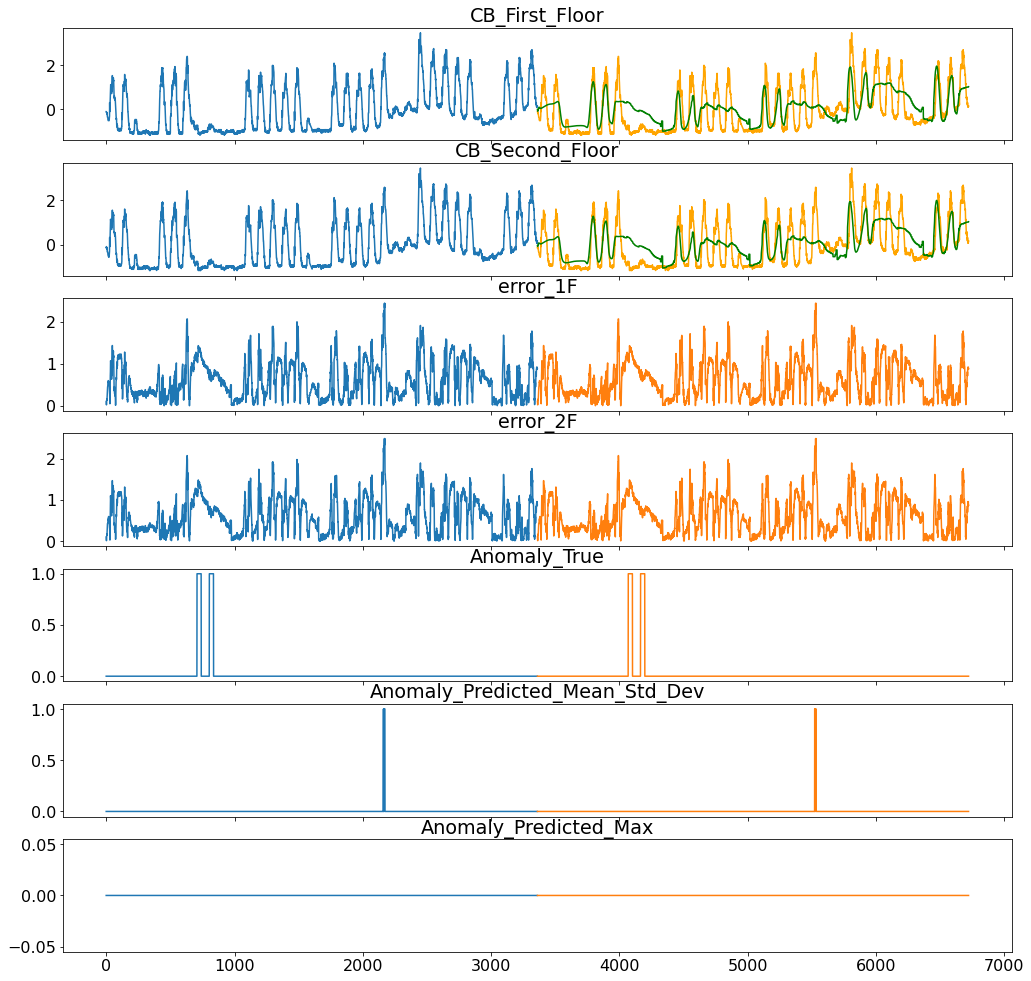

In [44]:
# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

Accuracy: 0.957
Precision: 0.0944
Recall: 0.0313
F1: 0.047


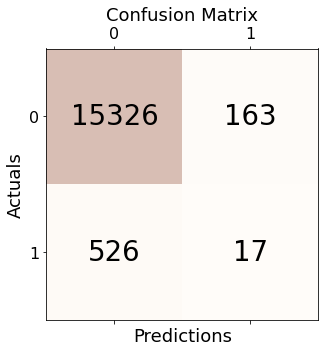

In [45]:
anomaly_predicted = anomaly_predicted_mean_std

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Accuracy: 0.9661
Precision: 0.0
Recall: 0.0
F1: 0.0


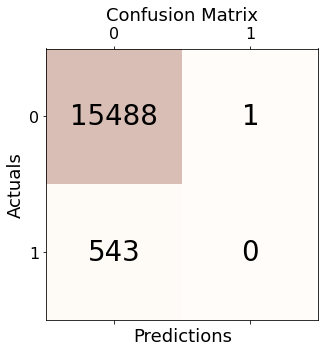

In [46]:
anomaly_predicted = anomaly_predicted_max

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()